# In this notebook, I use the OpenWeatherMap API to analyze historical air pollution data in New York City

In [117]:
import requests
import os
from dotenv import load_dotenv
import json

load_dotenv()
api_key = os.getenv("WEATHER_API_KEY")

In [118]:

def fetch_city_coordinates(api_key, city):
    url = f"http://api.openweathermap.org/geo/1.0/direct?q={city}&limit=5&appid={api_key}"
    response = requests.get(url)
    return response.json()

city_coordinates = fetch_city_coordinates(api_key, city="New York City")
print(json.dumps(city_coordinates, indent=4))

[
    {
        "name": "New York County",
        "local_names": {
            "el": "\u039d\u03ad\u03b1 \u03a5\u03cc\u03c1\u03ba\u03b7",
            "is": "N\u00fdja J\u00f3rv\u00edk",
            "pl": "Nowy Jork",
            "pt": "Nova Iorque",
            "ca": "Nova York",
            "cs": "New York",
            "eo": "Novjorko",
            "de": "New York",
            "fa": "\u0646\u06cc\u0648\u06cc\u0648\u0631\u06a9",
            "oc": "N\u00f2va York",
            "hi": "\u0928\u094d\u092f\u0942\u092f\u094a\u0930\u094d\u0915\u094d",
            "ar": "\u0646\u064a\u0648\u064a\u0648\u0631\u0643",
            "he": "\u05e0\u05d9\u05d5 \u05d9\u05d5\u05e8\u05e7",
            "kn": "\u0ca8\u0ccd\u0caf\u0cc2\u0caf\u0cca\u0cb0\u0ccd\u0c95\u0ccd",
            "ko": "\ub274\uc695",
            "gl": "Nova York",
            "zh": "\u7ebd\u7ea6/\u7d10\u7d04",
            "te": "\u0c28\u0c4d\u0c2f\u0c42\u0c2f\u0c4a\u0c30\u0c4d\u0c15\u0c4d",
            "fr": "New York",
           

In [119]:
def fetch_air_pollution_data(api_key, lat, lon, start, end):
    url = f"http://api.openweathermap.org/data/2.5/air_pollution/history?lat={lat}&lon={lon}&start={start}&end={end}&appid={api_key}"
    response = requests.get(url)
    return response.json()

air_pollution_data = fetch_air_pollution_data(api_key, lat="40.7127281", lon="-74.0060152", start=1606488670, end=1606747870)
#print(json.dumps(air_pollution_data, indent=4))

In [120]:
# Organizing data into a DataFrame

data_list = air_pollution_data['list']
df = pd.DataFrame(data_list)

# Converting UNIX timestamps to datetime
df['dt'] = pd.to_datetime(df['dt'], unit='s')

# Expanding the 'main' and 'components' dictionaries into separate columns
df_main = df['main'].apply(pd.Series)
df_components = df['components'].apply(pd.Series)

# Concatenating all data into one DataFrame
df = pd.concat([df.drop(['main', 'components'], axis=1), df_main, df_components], axis=1)
df.head()

,dt,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2020-11-27 15:00:00,4,1134.87,135.90,29.13,2.66,6.32,33.99,50.53,4.94
1,2020-11-27 16:00:00,2,620.84,51.41,31.53,9.21,14.42,16.51,24.08,3.17
2,2020-11-27 17:00:00,2,567.44,39.79,39.07,12.88,17.17,15.99,22.75,3.36
3,2020-11-27 18:00:00,2,547.41,33.98,46.61,13.05,18.84,15.55,22.25,3.61
4,2020-11-27 19:00:00,2,527.38,28.16,48.67,11.80,15.26,13.43,19.61,3.58


# Analysis

Let's analyze the data to find patterns. Specifically, let's investigate:

- Average levels of each pollutant over the time period
- Days with the highest pollution levels
- Days with the lowest pollution levels
- How pollution levels vary throughout the day.

In [121]:
#Average levels of each pollutant
mean_aqi = df['aqi'].mean()
mean_co = df['co'].mean()
mean_no = df['no'].mean()
mean_no2 = df['no2'].mean()
mean_o3 = df['o3'].mean()
mean_so2 = df['so2'].mean()
mean_pm2_5 = df['pm2_5'].mean()
mean_pm10 = df['pm10'].mean()
mean_nh3 = df['nh3'].mean()

print(f'Mean Air Quality Index: {round(mean_aqi, 3)}')
print(f'Mean Carbon Monoxide Concentration: {round(mean_co, 3)}')
print(f'Mean Nitrogen Monoxide Concentration: {round(mean_no, 3)}')
print(f'Mean Nitrogen Dioxide Concentration: {round(mean_no2, 3)}')
print(f'Mean Ozone Concentration: {round(mean_o3, 3)}')
print(f'Mean Sulphur Dioxide Concentration: {round(mean_so2, 3)}')
print(f'Mean Fine Particles Matter Concentration: {round(mean_pm2_5, 3)}')
print(f'Mean Coarse Particulate Matter Concentration: {round(mean_pm10, 3)}')
print(f'Mean Ammonia Concentration: {round(mean_nh3, 3)}')

Mean Air Quality Index: 2.236
Mean Carbon Monoxide Concentration: 558.119
Mean Nitrogen Monoxide Concentration: 28.412
Mean Nitrogen Dioxide Concentration: 45.904
Mean Ozone Concentration: 10.448
Mean Sulphur Dioxide Concentration: 7.569
Mean Fine Particles Matter Concentration: 15.486
Mean Coarse Particulate Matter Concentration: 22.172
Mean Ammonia Concentration: 3.045


## Let's visualize these average levels using a bar chart 

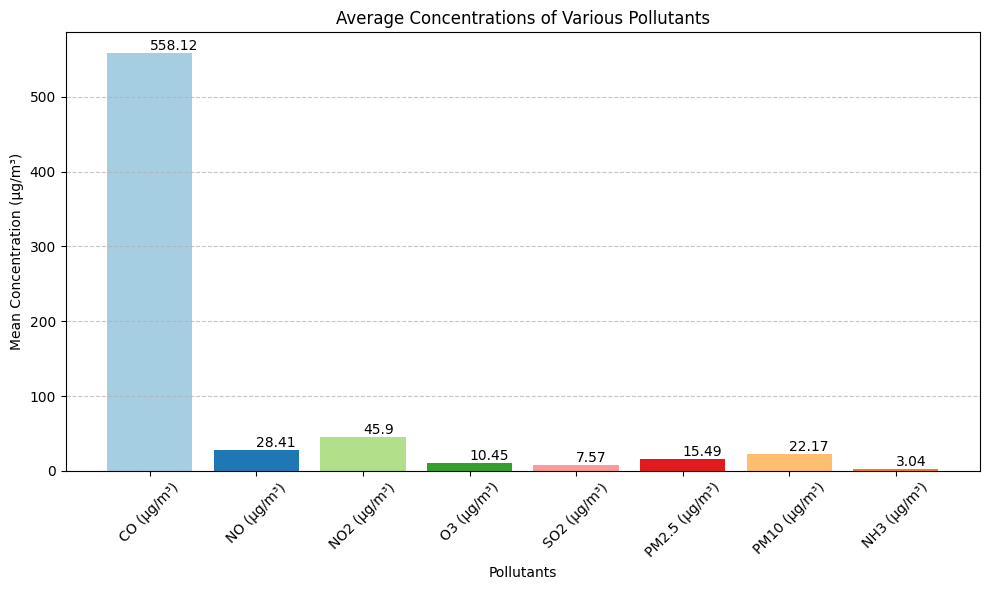

In [122]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a dictionary with the mean values
pollutant_means = {
    'CO (µg/m³)': 558.119,
    'NO (µg/m³)': 28.412,
    'NO2 (µg/m³)': 45.904,
    'O3 (µg/m³)': 10.448,
    'SO2 (µg/m³)': 7.569,
    'PM2.5 (µg/m³)': 15.486,
    'PM10 (µg/m³)': 22.172,
    'NH3 (µg/m³)': 3.045
}

# Convert the dictionary to a DataFrame for easier plotting
df_means = pd.DataFrame(list(pollutant_means.items()), columns=['Pollutant', 'Mean Concentration'])

plt.figure(figsize=(10, 6))
bars = plt.bar(df_means['Pollutant'], df_means['Mean Concentration'], color=plt.cm.Paired(range(len(df_means))))

plt.title('Average Concentrations of Various Pollutants')
plt.xlabel('Pollutants')
plt.ylabel('Mean Concentration (µg/m³)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')  # va: vertical alignment

plt.tight_layout()
plt.show()


# We can also graph carbon monoxide levles over time

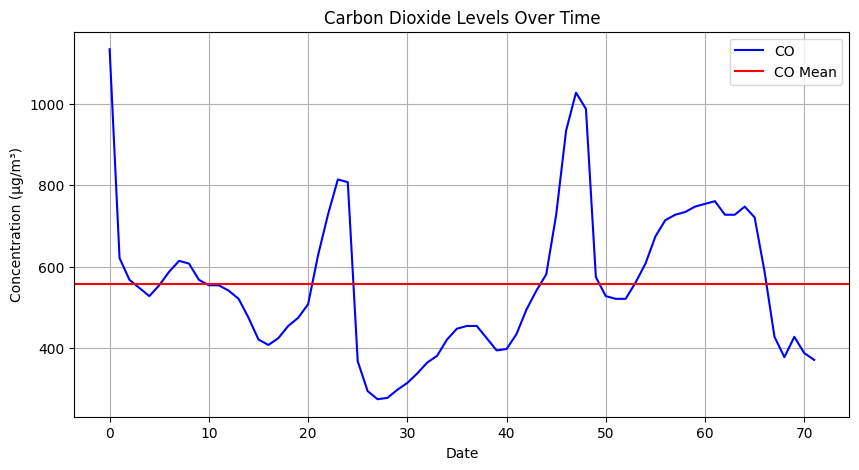

In [123]:
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['co'], linestyle='-', color='blue', label='CO')
plt.axhline(y=mean_co, color='red', linestyle='-', label='CO Mean')
plt.title('Carbon Dioxide Levels Over Time')
plt.xlabel('Date')
plt.ylabel('Concentration (µg/m³)')
plt.legend()
plt.grid(True)
plt.show()

# Let's also graph the levels of the other pollutants

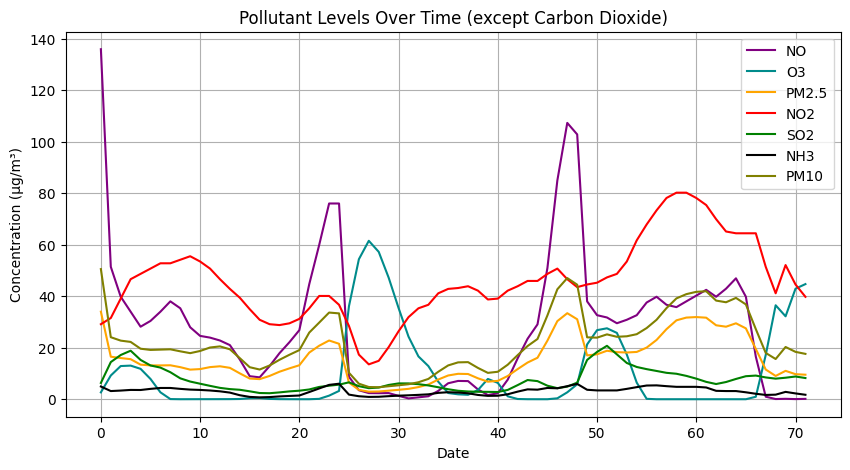

In [124]:
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['no'], linestyle='-', color='purple', label='NO')
plt.plot(df.index, df['o3'], linestyle='-', color='darkcyan', label='O3')
plt.plot(df.index, df['pm2_5'], linestyle='-', color='orange', label='PM2.5')
plt.plot(df.index, df['no2'], linestyle='-', color='red', label='NO2')
plt.plot(df.index, df['so2'], linestyle='-', color='green', label='SO2')
plt.plot(df.index, df['nh3'], linestyle='-', color='black', label='NH3')
plt.plot(df.index, df['pm10'], linestyle='-', color='olive', label='PM10')
plt.title('Pollutant Levels Over Time (except Carbon Dioxide)')
plt.xlabel('Date')
plt.ylabel('Concentration (µg/m³)')
plt.legend()
plt.grid(True)
plt.show()
#plt.plot(df.index, df['co'], marker='o', linestyle='-', color='lightblue', label='CO')

In [125]:
concentration_sum = df['no'] + df['co'] + df['o3'] + df['pm2_5'] + df['no2'] + df['so2'] + df['nh3'] + df['pm10']
smallest_five = concentration_sum.nsmallest(5)
largest_five = concentration_sum.nlargest(5)
corresponding_smallest_dates = df.loc[smallest_five.index, 'dt']
corresponding_largest_dates = df.loc[largest_five.index, 'dt']
corresponding_largest_dates

0    2020-11-27 15:00:00
47   2020-11-29 14:00:00
48   2020-11-29 15:00:00
46   2020-11-29 13:00:00
23   2020-11-28 14:00:00
Name: dt, dtype: datetime64[ns]

# Let's also look at the levels of total concentration of all the pollutants combined

In [126]:
concentration_sum = df[['no', 'co', 'o3', 'pm2_5', 'no2', 'so2', 'nh3', 'pm10']].sum(axis=1)
df['total_concentration'] = concentration_sum

# Finding smallest and largest total concentrations
smallest_five = concentration_sum.nsmallest(5)
largest_five = concentration_sum.nlargest(5)

# Display corresponding dates and concentration totals
corresponding_smallest_dates = df.loc[smallest_five.index, ['dt', 'total_concentration']]
corresponding_largest_dates = df.loc[largest_five.index, ['dt', 'total_concentration']]

# Display the results
print("Dates with the smallest total concentrations:")
print(corresponding_smallest_dates)
print("\nDates with the largest total concentrations:")
print(corresponding_largest_dates)

Dates with the smallest total concentrations:
                    dt  total_concentration
27 2020-11-28 18:00:00               364.00
28 2020-11-28 19:00:00               364.65
29 2020-11-28 20:00:00               381.97
26 2020-11-28 17:00:00               384.78
30 2020-11-28 21:00:00               393.45

Dates with the largest total concentrations:
                    dt  total_concentration
0  2020-11-27 15:00:00              1398.34
47 2020-11-29 14:00:00              1275.04
48 2020-11-29 15:00:00              1228.08
46 2020-11-29 13:00:00              1152.16
23 2020-11-28 14:00:00               999.20


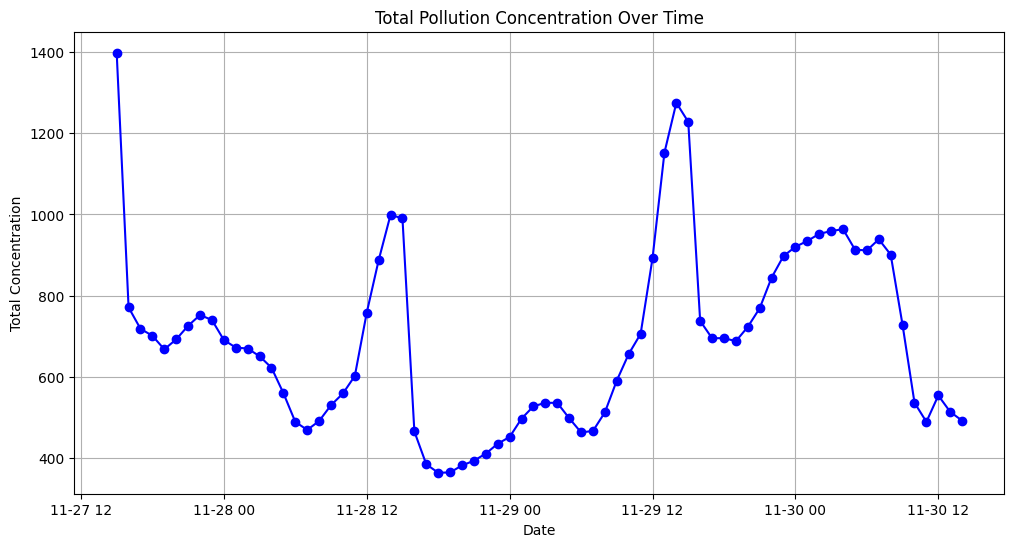

In [115]:
import matplotlib.pyplot as plt

df.set_index('dt', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['total_concentration'], marker='o', linestyle='-', color='blue')
plt.title('Total Pollution Concentration Over Time')
plt.xlabel('Date')
plt.ylabel('Total Concentration')
plt.grid(True)
plt.show()